In [1]:
#necessary modules
from matplotlib import pyplot as plt
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
register_matplotlib_converters()
from statsmodels.tsa.vector_ar.vecm import VECM

%matplotlib inline

#Granger Causality function-çalışıyor
#The row are the response (y) and the columns are the predictor series (x).
def grangerCausality(data,variables,test='ssr_chi2test',verbose=False,lag=10):
    x_train=DF(np.zeros((len(variables),len(variables))),
               columns=variables,index=variables)
    for c in x_train.columns:
        for r in x_train.index:
            test_result=grangercausalitytests(data[[r,c]],maxlag=lag,verbose=False)
            p_values=[round(test_result[i+1][0][test][1],4) for i in range (lag)]
            if verbose:
                print(f'Y={r},X={c},P-values={p_values}')
            min_p_values=np.min(p_values)
            x_train.loc[r,c]=min_p_values
    x_train.columns=[var+'_x' for var in variables]
    x_train.index=[var+'_y' for var in variables]
    return x_train          
    

#Cointegration:Johansen Test-Çalışıyor
def cointegrationTest(data,alpha=0.05):
    out=coint_johansen(data,-1,5)
    d={'0.90': 0 , '0.95' :1, '0.99' :2}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6): return str(val).ljust(length)
    print('Name :: Test Stat > C(95%) => Signif \n','--'*20)
    for col,trace,cvt in zip(data.columns,traces,cvts):
        print(adjust(col),'::',adjust(round(trace,2),9),">",
             adjust(cvt,8),"=>", trace>cvt)
    return out.eig, out.evec[:,0] / out.evec[:,0][0]

#Variational Model-Çalışıyor
def varModel(data,maxLag=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=maxLag,ic='aic')
    print(res.summary())

#ADFuller Test
def adfuller_test(data,signif=0.05,name='',verbose=False):
    r=adfuller(data,autolag='AIC')
    output={'test_statistics': round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),
           'n_obs':r[3]}
    p_value=output['pvalue']
    def adjust(val,length=6): return str(val).ljust(length)
    #Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"',"\n",'-'*47)
    print(f'Null Hypothesis:Data has unit root.Non-stationary.')
    print(f'Significance Level ={signif}')
    print(f'Test statistics    ={output["test_statistics"]}')
    print(f'No. Lags chosen    ={output["n_lags"]}')
          
    for key,val in r[4].items():
        print(f'Critical value{adjust(key,6)}={round(val,3)}')
    
    if p_value<=signif:
        print(f'=> P-Value={p_value}.Rejecting Null Hypothesis.')
        print(f'=> Series is Stationary.')
    else:
        print(f'=> P-Value={p_value}.Weak evidence to reject the Null Hypothesis')

def adfForAll(data):
    for name, column in data.iteritems():
        adfuller_test(column,name=column.name)
        print('\n')

#Durbin-Watson Statistic-Çalısıyor
def DW(data,lags=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=lags,ic='aic')
    out=durbin_watson(res.resid)
    for col,val in zip(data.columns,out):
        print((col),':',round(val,2))

In [2]:
original_data=pd.read_excel("exampleset.xls",index_col='Time')
#split data into test and train 
train_data=original_data[original_data['Training ']==True]
test_data=original_data[original_data['Training ']==False]
#we can drop last column from our data which has label Training
test_data=test_data.drop(['Training '],axis=1)
train_data=train_data.drop(['Training '],axis=1)
#x_centered
x = train_data.values
x_centered =DF(x - np.mean(x, axis=0),index=train_data.index, columns=train_data.columns)


In [3]:
#öncelikle bizim data serimiz stationary mi diye Augmented Dickey-Fuller testi ile kontrol ediyoruz
#ilk olarak test datasıın orjinal haline bakıyorum
adfForAll(train_data)

Augmented Dickey-Fuller Test on "SeriesA" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.2835
No. Lags chosen    =12
Critical value1%    =-3.464
Critical value5%    =-2.876
Critical value10%   =-2.575
=> P-Value=0.6367.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesB" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.0574
No. Lags chosen    =0
Critical value1%    =-3.462
Critical value5%    =-2.876
Critical value10%   =-2.574
=> P-Value=0.7318.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesC" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.9374
No. Lags chosen    =1
Critical value1%    =-3.462
Critical value5%    =

In [4]:
#Göründüğü üzere zaman serilerimiz non-stationary
#Bu yüzden first differenceların stationary olup olmadıklarına bakalım
adfForAll(train_data.diff().dropna())

Augmented Dickey-Fuller Test on "SeriesA" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-4.0341
No. Lags chosen    =11
Critical value1%    =-3.464
Critical value5%    =-2.876
Critical value10%   =-2.575
=> P-Value=0.0012.Rejecting Null Hypothesis.
=> Series is Stationary.


Augmented Dickey-Fuller Test on "SeriesB" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-15.8046
No. Lags chosen    =0
Critical value1%    =-3.462
Critical value5%    =-2.876
Critical value10%   =-2.574
=> P-Value=0.0.Rejecting Null Hypothesis.
=> Series is Stationary.


Augmented Dickey-Fuller Test on "SeriesC" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-18.1266
No. Lags chosen    =0
Critical value1%    =-3.462
Critic

First difference train_data bize, serilerin stationary hale geldiğini söylüyor.
Bu yüzden öncelikle VAR ve VECM modelllerinde veri modellemeden önce train ve test data da'nın first differencelarını kullanmamız
lazım.

In [5]:
train_data_1=train_data.diff().dropna()

Buradaki önemli bir noktada Granger-Causality 'e bakmadan önce zaman serilerinin stationary olması gerektiği bilgisi, bu yüzden de 
zaman serilerini stationary yapmak önemli.
Bundan sonra zaman serilerinin Granger-Causality ile nedensellik barındırıp barındırmadıklarına bakalım.

In [6]:
grangerCausality(train_data_1,variables=train_data_1.columns)

,SeriesA_x,SeriesB_x,SeriesC_x,SeriesD_x,SeriesE_x,SeriesF_x,SeriesG_x
SeriesA_y,1.0000,0.0136,0.0459,0.4279,0.1188,0.2656,0.3166
SeriesB_y,0.0000,1.0000,0.0494,0.0019,0.0087,0.0074,0.0012
SeriesC_y,0.1017,0.1512,1.0000,0.0001,0.0010,0.1145,0.1519
SeriesD_y,0.0015,0.0194,0.3491,1.0000,0.0000,0.0001,0.1054
SeriesE_y,0.1745,0.0328,0.1658,0.0131,1.0000,0.1260,0.1549
SeriesF_y,0.2699,0.0606,0.0292,0.1618,0.1376,1.0000,0.0708
SeriesG_y,0.0284,0.1547,0.1129,0.2755,0.0069,0.0145,1.0000


BU matriste satırlar etkilenen değişkenleri, stünlar etkileyen değişkenleri temsil ediyor. Örneğin,1. satır 2.sütün değeri
olan **0.0136**<**0.05** için null hypothesis red edilir ve buda B serisinin A serisinin nedeni olduğu hakkında bize bilgi verir.
Aynı şekilde 2.satır 1.sütüna baktığımızdaki 0 değeri de bize A serisinin B nin cause 'u olduğunu söyler.

# P1 Portfolio Oluşturuması

öncelikle train setimizin ilk dört zaman serisinden oluşan bir zaman serisi seti yapalım

In [7]:
#small set consist of A,B,C,D time series
train_data_2=train_data_1[['SeriesA','SeriesB','SeriesC','SeriesD']]
train_data_2.head()

,SeriesA,SeriesB,SeriesC,SeriesD
Time,,,,
04:32:00,-0.002,-0.003,-0.001,0.004
04:34:00,0.018,0.013,0.004,0.010
04:36:00,0.000,-0.002,0.000,-0.001
04:38:00,0.024,0.006,0.000,0.007
04:40:00,-0.003,-0.002,0.006,0.004


Şimdi Johansen cointegration testi vasıtasıyla cointegration sabitlerini bulalım:

In [8]:
ozdeger,ozvektor=cointegrationTest(train_data_2)
ozvektor

Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
SeriesA :: 171.27    > 40.1749  => True
SeriesB :: 103.9     > 24.2761  => True
SeriesC :: 58.42     > 12.3212  => True
SeriesD :: 28.13     > 4.1296   => True


array([ 1.        ,  0.42670303, -0.63525594, -0.24478296])

Burada ozvektor isimli değişkende cointegration coefficientları(normalize) bulunuyor.
Bizde buradan P1 adlı portfolioyu oluşturalım:

In [9]:
train_data_2['P1']=ozvektor[0]*train_data_2['SeriesA']+ozvektor[1]*train_data_2['SeriesB']+ozvektor[2]*train_data_2['SeriesC']+ozvektor[3]*train_data_2['SeriesD']
train_data_2.head(10)

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SeriesA,SeriesB,SeriesC,SeriesD,P1
Time,,,,,
04:32:00,-0.002,-0.003,-0.001,0.004,-0.003624
04:34:00,0.018,0.013,0.004,0.010,0.018558
04:36:00,0.000,-0.002,0.000,-0.001,-0.000609
04:38:00,0.024,0.006,0.000,0.007,0.024847
04:40:00,-0.003,-0.002,0.006,0.004,-0.008644
04:42:00,0.001,0.005,0.000,0.010,0.000686
04:44:00,0.005,0.010,0.007,0.015,0.001148
04:46:00,0.015,0.004,0.007,0.009,0.010057
04:48:00,-0.013,-0.007,0.001,-0.007,-0.014909


Buradaki P1 isimli cointegrated seriyi görelim:

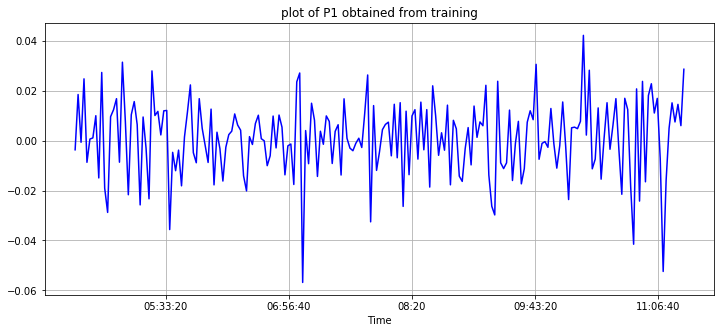

In [10]:
axes=train_data_2.P1.plot(color='blue',label='Actual SeriesA',grid=True,title="plot of P1 obtained from training",figsize=(12,5))

Şimdi de P1 serisinin 5 lik ve 10 luk Moving averagelarını bulalım ve hepsini bir arada görüntüleyelim:

In [11]:
train_data_2['P1MA5'] = train_data_2.iloc[:,4].rolling(window=5).mean()
train_data_2['P1MA10'] = train_data_2.iloc[:,4].rolling(window=10).mean()

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
train_data_2.head(10)

,SeriesA,SeriesB,SeriesC,SeriesD,P1,P1MA5,P1MA10
Time,,,,,,,
04:32:00,-0.002,-0.003,-0.001,0.004,-0.003624,NaN,NaN
04:34:00,0.018,0.013,0.004,0.010,0.018558,NaN,NaN
04:36:00,0.000,-0.002,0.000,-0.001,-0.000609,NaN,NaN
04:38:00,0.024,0.006,0.000,0.007,0.024847,NaN,NaN
04:40:00,-0.003,-0.002,0.006,0.004,-0.008644,0.006106,NaN
04:42:00,0.001,0.005,0.000,0.010,0.000686,0.006968,NaN
04:44:00,0.005,0.010,0.007,0.015,0.001148,0.003486,NaN
04:46:00,0.015,0.004,0.007,0.009,0.010057,0.005619,NaN
04:48:00,-0.013,-0.007,0.001,-0.007,-0.014909,-0.002332,NaN


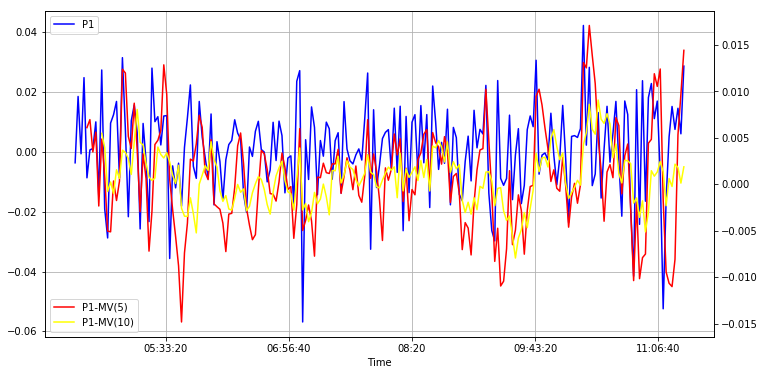

In [13]:
ax1=train_data_2.iloc[:,4].plot(color='blue',label='P1',grid=True,figsize=(12,6))
ax2=train_data_2.iloc[:,5].plot(color='red',label='P1-MV(5)',grid=True,secondary_y=True)
ax3=train_data_2.iloc[:,6].plot(color='yellow',label='P1-MV(10)',grid=True,secondary_y=True)
ax1.legend(loc=2)
ax2.legend(loc=3)
ax3.legend(loc=3)

# VECM: P1, SeriesE, SeriesF, SeriesG

Öncelikle P1,Series5, Series6, Series 7 şeklinde bir veri yapımızı kuralım:

In [14]:
train_data_3=train_data_1[['SeriesE','SeriesF','SeriesG']]
train_data_3.insert(loc=0, column='P1', value=train_data_2['P1'])

In [15]:
train_data_3.head(10)

,P1,SeriesE,SeriesF,SeriesG
Time,,,,
04:32:00,-0.003624,0.012,0.008,-0.001
04:34:00,0.018558,0.018,0.054,0.001
04:36:00,-0.000609,0.005,-0.010,-0.005
04:38:00,0.024847,0.023,0.019,0.000
04:40:00,-0.008644,0.003,-0.023,0.005
04:42:00,0.000686,0.011,0.002,0.000
04:44:00,0.001148,0.035,-0.007,0.018
04:46:00,0.010057,0.005,0.025,-0.001
04:48:00,-0.014909,-0.005,0.000,-0.006


Artık VECM modelimizi kurabiliriz. Burada %95 güven aralığında 10 adet ileri tahmini yapacak modeli kuruyoruz

In [16]:
#VECM Modeli
#lag=4 linear trend within the cointegration relation
vecm = VECM(endog = train_data_3, k_ar_diff = 4, coint_rank = 3, deterministic = 'cili')
vecm_fit = vecm.fit()
#model uzerinden 226 tahin noktası buluyoruz.(alt üst güven aralığı dahil)
forecast, lower, upper = vecm_fit.predict(226, 0.05)
"""print("lower bounds of confidence intervals:")
print(lower.round(3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))
"""

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


'print("lower bounds of confidence intervals:")\nprint(lower.round(3))\nprint("\npoint forecasts:")\nprint(forecast.round(3))\nprint("\nupper bounds of confidence intervals:")\nprint(upper.round(3))\n'

tahmin modeline göre bakalım son train_data setinde P1 neymiş:

[[-1.83357719  0.10212057  0.40879299]
 [-0.49668184  0.11083829  0.0068358 ]
 [-0.42293178  0.5717719  -0.97314102]
 [-0.15814096  0.26407432  0.05426343]]


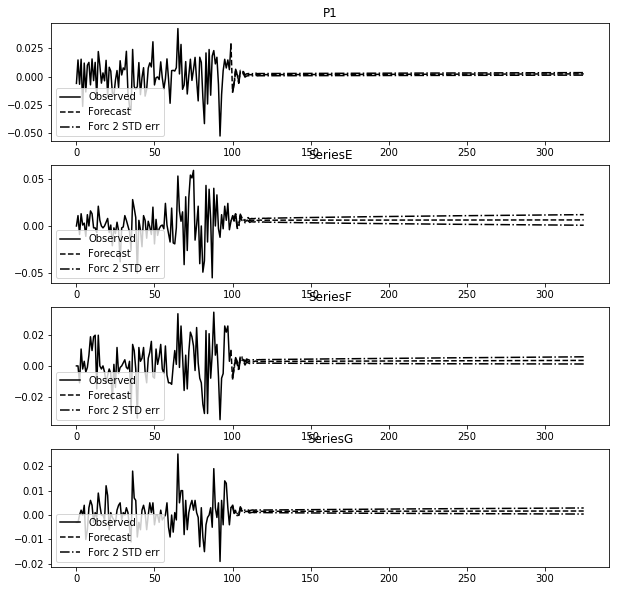

In [17]:

vecm_fit.plot_forecast(226,0.95,n_last_obs=100)
print(vecm_fit.alpha)

Son değer ile tahmin değerlerinin karşılaştırırsak görüyoru ki bir sonraki adımda güven aralıkları da dahil olmak üzere P1
serisi düşüşe girecek.

# Test data seti üzerinden karşılaştırma

In [18]:
#test data seti üzerinden P1 portfolio'sunu oluşturalım
test_data_1=test_data.diff().dropna()

test_data_1['P1']=ozvektor[0]*test_data_1['SeriesA']+ozvektor[1]*test_data_1['SeriesB']+ozvektor[2]*test_data_1['SeriesC']+ozvektor[3]*test_data_1['SeriesD']
test_data_2=test_data_1[['P1','SeriesE','SeriesF','SeriesG']]
test_data_2['P1']=test_data_2
test_data_2.head()

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,P1,SeriesE,SeriesF,SeriesG
Time,,,,
11:28:00,0.047611,0.065,0.075,0.019
11:30:00,0.003853,-0.066,-0.027,-0.001
11:32:00,0.006903,0.028,0.031,0.028
11:34:00,0.037618,0.107,0.104,0.091
11:36:00,0.019190,0.035,0.002,0.024


In [19]:
#prediction inverse
prediction_vecm=pd.DataFrame(forecast,index=test_data_2.index,columns=test_data_2.columns)
prediction_vecm=test_data_2+prediction_vecm
prediction_vecm.head()

,P1,SeriesE,SeriesF,SeriesG
Time,,,,
11:28:00,0.034113,0.075477,0.067013,0.022882
11:30:00,-0.002501,-0.059734,-0.028043,0.000021
11:32:00,0.012408,0.040941,0.035482,0.029541
11:34:00,0.039225,0.105628,0.106065,0.091143
11:36:00,0.014114,0.035277,-0.000195,0.023833


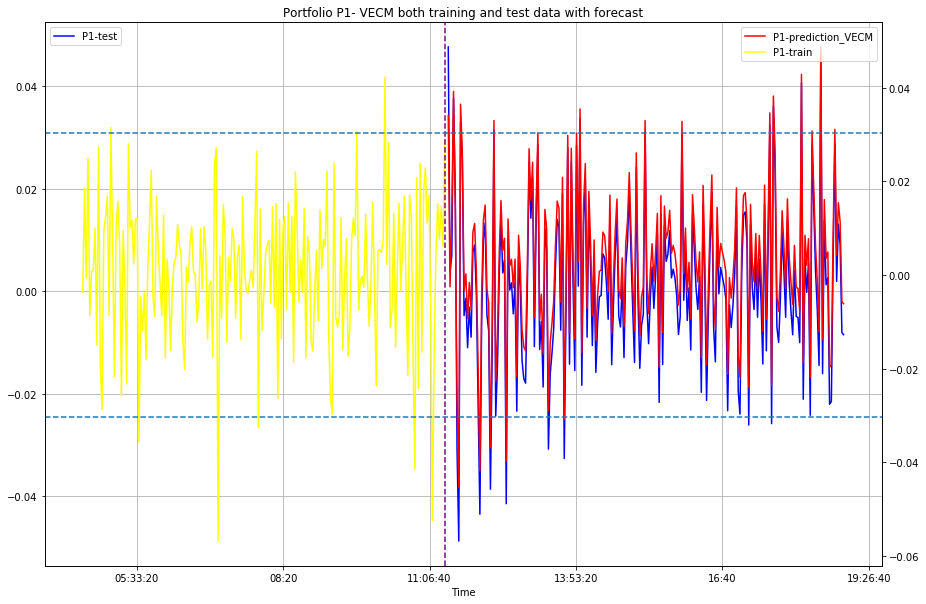

In [20]:
axs1=test_data_2.P1.plot(color='blue',label='P1-test',grid=True,figsize=(15,10))

axs2=prediction_vecm.P1.plot(color='red',label='P1-prediction_VECM',grid=True,secondary_y=True)
axs3=train_data_3.P1.plot(color='yellow',label="P1-train",grid=True,secondary_y=True)
axs3.axvline(x=train_data_3.index[-1], color='purple',ls='--')
axs3.axhline(y=2*train_data_3.P1.describe()[2],ls='--')#+2*standart sapma çizgisi
axs3.axhline(y=-2*train_data_3.P1.describe()[2],ls='--')#-2*standart sapma çizgisi
plt.title('Portfolio P1- VECM both training and test data with forecast')
axs3.legend(loc=1)
axs1.legend(loc=2)

# P1 Level Analysis +VECM Model Forecast

In [32]:

p1_1=ozvektor[0]*train_data['SeriesA']+ozvektor[1]*train_data['SeriesB']+ozvektor[2]*train_data['SeriesC']+ozvektor[3]*train_data['SeriesD']
train_data_level=train_data[['SeriesE','SeriesF','SeriesG']]
train_data_level['P1']=p1_1
train_data_level=train_data_level[['P1','SeriesE','SeriesF','SeriesG']]
test_data_level=test_data[['SeriesE','SeriesF','SeriesG']]
test_data_level['P1']=ozvektor[0]*test_data['SeriesA']+ozvektor[1]*test_data['SeriesB']+ozvektor[2]*test_data['SeriesC']+ozvektor[3]*test_data['SeriesD']
test_data_level=test_data_level[['P1','SeriesE','SeriesF','SeriesG']]
train_data_level.tail()


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,P1,SeriesE,SeriesF,SeriesG
Time,,,,
11:16:00,8.407056,142.525,71.047,109.896
11:18:00,8.414605,142.531,71.069,109.909
11:20:00,8.429217,142.555,71.095,109.912
11:22:00,8.435285,142.551,71.098,109.908
11:24:00,8.463978,142.556,71.108,109.911


In [41]:
train_data_level["P1"]=train_data_level["P1"]-np.mean(train_data_level["P1"],axis=0)
test_data_level["P1"]=test_data_level["P1"]-np.mean(test_data_level["P1"],axis=0)
test_data_level["P1"].head()

Time
11:26:00   -0.054394
11:28:00   -0.006783
11:30:00   -0.002930
11:32:00    0.003973
11:34:00    0.041591
Name: P1, dtype: float64

In [49]:
#VECM Modeli
#lag=4 linear trend within the cointegration relation
vecm = VECM(endog = train_data_level, k_ar_diff = 4, coint_rank = 3, deterministic = 'cili')
vecm_fit = vecm.fit()
#model uzerinden 226 tahin noktası buluyoruz.(alt üst güven aralığı dahil)
forecast, lower, upper = vecm_fit.predict(227, 0.05)
prediction_vecm=pd.DataFrame(forecast,index=test_data_level.index,columns=test_data_level.columns)
prediction_vecm=test_data_level+prediction_vecm
prediction_lower=pd.DataFrame(lower,index=test_data_level.index,columns=test_data_level.columns)
prediction_lower=test_data_level+prediction_lower
prediction_upper=pd.DataFrame(upper,index=test_data_level.index,columns=test_data_level.columns)
prediction_upper=test_data_level+prediction_upper

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


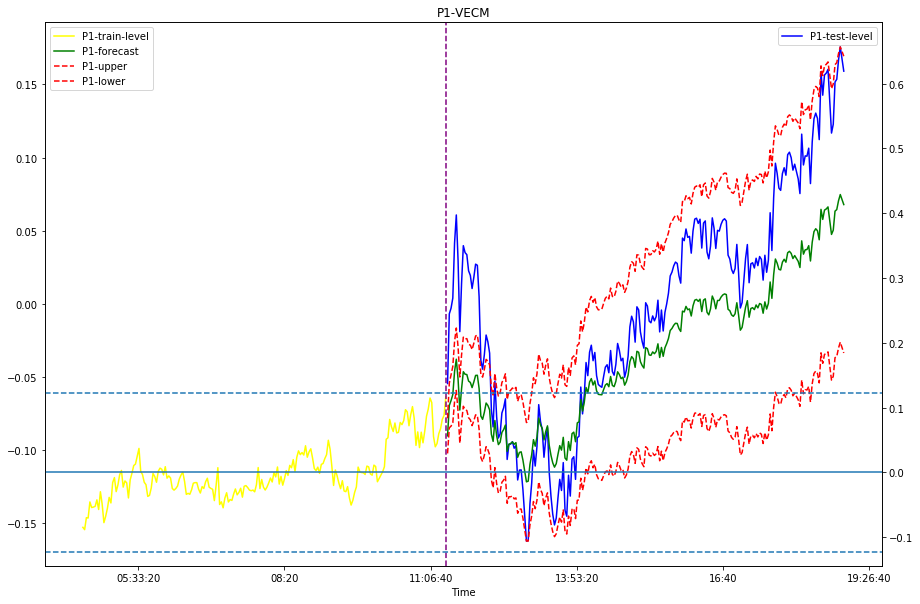

In [63]:
ax1= test_data_level.P1.plot(color='blue',label='P1-test-level',title="P1-VECM",figsize=(15,10))
ax2= train_data_level.P1.plot(color='yellow',label="P1-train-level",secondary_y=True)
ax3=prediction_vecm.P1.plot(color="green",label="P1-forecast", secondary_y=True)
ax4=prediction_upper.P1.plot(color="red",label="P1-upper",ls='--', secondary_y=True)
ax5=prediction_lower.P1.plot(color="red",label="P1-lower", ls='--', secondary_y=True)
ax2.axvline(x=train_data_level.index[-1], color='purple',ls='--')

ax2.axhline(y=3*train_data_level.P1.describe()[2],ls='--')#+3*standart sapma çizgisi
ax2.axhline(y=-3*train_data_level.P1.describe()[2],ls='--')#-3*standart sapma çizgisi
ax2.axhline(y=0)
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=2)
ax4.legend(loc=2)

In [57]:
from sklearn.metrics import *
from math import sqrt
forecast_error=[test_data_level.P1[i]-prediction_vecm.P1[i] for i in range(len(test_data_2))]
bias=sum(forecast_error)*1.0/len(test_data_level)
print("Bias:{}".format(bias))
mae=mean_absolute_error(test_data_level.P1,prediction_vecm.P1)
print('Mean Absulate Error:{}'.format(mae))
mse=mean_squared_error(test_data_level.P1,prediction_vecm.P1)
rmse=sqrt(mse)
print("Mean Square Error: {}".format(mse))
print("Root Mean Square Error: {}".format(rmse))

Bias:-0.18741981012979628
Mean Absulate Error:0.1885397424639053
Mean Square Error: 0.03721946669065516
Root Mean Square Error: 0.19292347366418416


# VAR Model : P1-Level

In [60]:
model = smt.VAR(train_data_level)
res = model.fit(maxlags=15,ic='bic')
res.summary()
#using lag=4 we try to predict next 227 points which is P1 portfolio
prediction=res.forecast(train_data_level.values[-4:],227)
pred_df=pd.DataFrame(prediction,index=test_data_level.index,columns=test_data_level.columns)
pred_inverse=pred_df.cumsum()
pred_df=pred_inverse+test_data_level
pred_df.head()

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,P1,SeriesE,SeriesF,SeriesG
Time,,,,
11:26:00,0.055871,285.120738,142.219386,219.830331
11:28:00,0.208051,427.738877,213.393777,329.758923
11:30:00,0.311288,570.224156,284.462698,439.666723
11:32:00,0.412844,712.801373,355.586592,549.602689
11:34:00,0.540781,855.455377,426.780833,659.600789


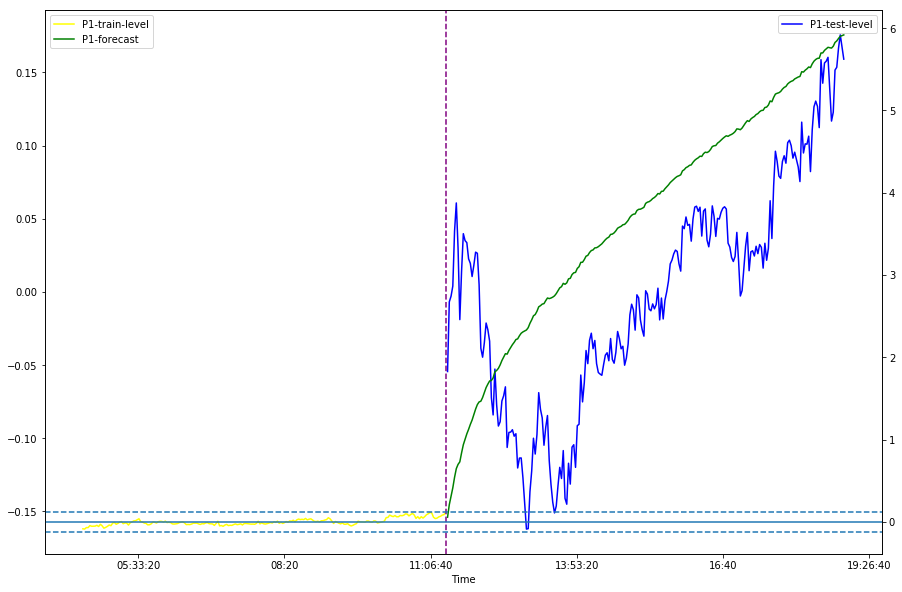

In [61]:
ax1= test_data_level.P1.plot(color='blue',label='P1-test-level',figsize=(15,10))
ax2= train_data_level.P1.plot(color='yellow',label="P1-train-level",secondary_y=True)
ax3=pred_df.P1.plot(color="green",label="P1-forecast", secondary_y=True)

ax2.axvline(x=train_data_level.index[-1], color='purple',ls='--')

ax2.axhline(y=3*train_data_level.P1.describe()[2],ls='--')#+3*standart sapma çizgisi
ax2.axhline(y=-3*train_data_level.P1.describe()[2],ls='--')#-3*standart sapma çizgisi
ax2.axhline(y=0)
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=2)


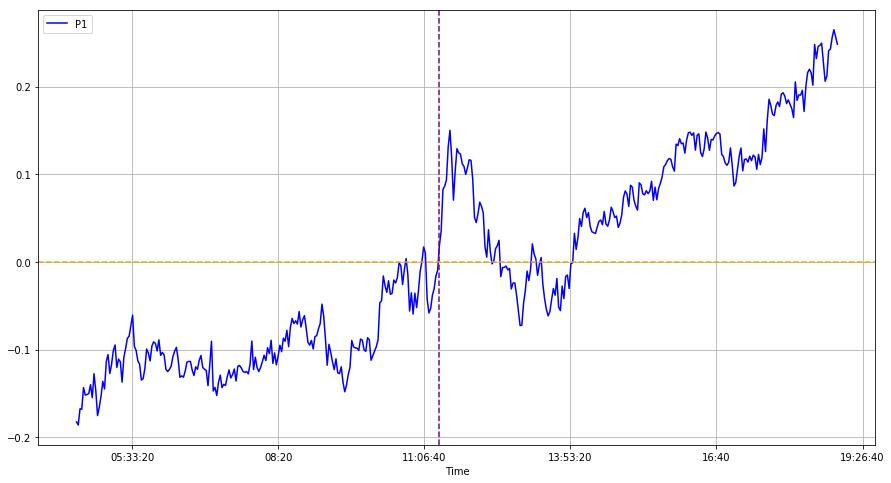

In [27]:
#axs1= test_data_level.P1.plot(color='blue',label='P1-test-level',figsize=(15,10))
#ax1= train_data_level.P1.plot(color='yellow',label="P1-train-level",secondary_y=True)

#ax1.axvline(x=train_data_level.index[-1], color='purple',ls='--')
#ax1.axhline(y=2*train_data_level.P1.describe()[2],ls='--')#+2*standart sapma çizgisi
#ax1.axhline(y=-2*train_data_level.P1.describe()[2],ls='--')#-2*standart sapma çizgisi
p1_2=ozvektor[0]*original_data['SeriesA']+ozvektor[1]*original_data['SeriesB']+ozvektor[2]*original_data['SeriesC']+ozvektor[3]*original_data['SeriesD']
#ax1.axhline(y=0)
p1_2 = p1_2 - np.mean(p1_2, axis=0)
train_data_level["P1"]=train_data_level["P1"]-np.mean(train_data_level["P1"],axis=0)
test_data_level["P1"]=test_data_level["P1"]-np.mean(test_data_level["P1"],axis=0)
ax1=p1_2.plot(color='blue', label="P1",grid=True, figsize=(15,8))
ax1.axvline(x=train_data_level.index[-1], color='purple',ls='--')
ax1.axhline(y=0, color="orange", ls="--")
ax1.legend(loc=2)

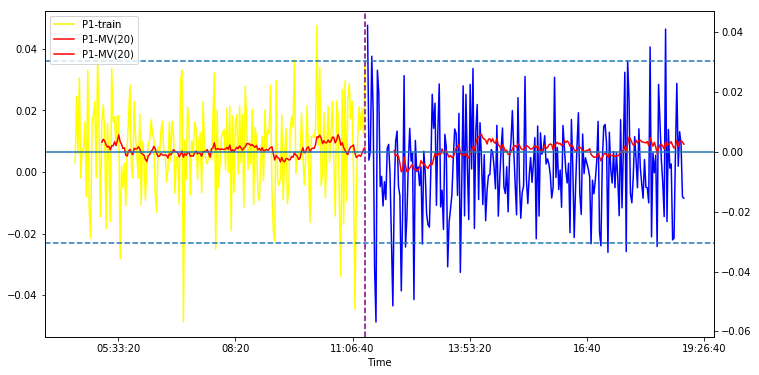

In [28]:
axs1=test_data_2.P1.plot(color='blue',label='P1-test',figsize=(12,6))
ax1=train_data_3.P1.plot(color='yellow',label="P1-train",secondary_y=True)
ax2=train_data_3.P1MA20.plot(color='red',label="P1-MV(20)",secondary_y=True)
ax3=test_data_2.P1MA20.plot(color='red',label="P1-MV(20)",secondary_y=True)
ax1.axvline(x=train_data_3.index[-1], color='purple',ls='--')
ax1.axhline(y=2*train_data_3.P1.describe()[2],ls='--')#+2*standart sapma çizgisi
ax1.axhline(y=-2*train_data_3.P1.describe()[2],ls='--')#-2*standart sapma çizgisi
ax1.axhline(y=0)
ax2.legend(loc=1)
axs1.legend(loc=2)
ax2.legend(loc=2)

# VECM forecast error

In [25]:
from sklearn.metrics import *
from math import sqrt
forecast_error=[test_data_2.P1[i]-prediction_vecm.P1[i] for i in range(len(test_data_2))]
bias=sum(forecast_error)*1.0/len(test_data_2)
print("Bias:{}".format(bias))
mae=mean_absolute_error(test_data_2.P1,prediction_vecm.P1)
print('Mean Absulate Error:{}'.format(mae))
mse=mean_squared_error(test_data_2.P1,prediction_vecm.P1)
rmse=sqrt(mse)
print("Mean Square Error: {}".format(mse))
print("Root Mean Square Error: {}".format(rmse))

Bias:-0.0018869805554455525
Mean Absulate Error:0.0021075825454272843
Mean Square Error: 5.295894992564365e-06
Root Mean Square Error: 0.0023012811633010785


# VAR Model: P1, SeriesE ,SeriesF, SeriesG

Bu kısımda VAR modeli için gerekli kodların hepsi mecut. Lakin buradaki VAR modeline P1,SeriesE,SeriesE ,SeriesF, SeriesG
şeklinde bir veri üzerinde hesaplama yapmasını istediğimizde ve özete baktığımızda hiçbir ilişki bulamamakta. Aslında bunu 
beklenen birşey olarak görüyorum. Bunun sebebi de şu ilk başta bulduğumuz cointegrated seri P1 için kullandığımız cointegration constantlarını bulurken aldğımız test sonucu cevaplarında serinin cointegrated olmadığını görüyoruz.
Bu durumda VAR modelinin serinin stationary olduğu durumda bile bize sonuş vermemesi normal geldi bana.
Burad P1 gibi bir portfolio oluşturulacak ve takip edilecekse daha sitematik bir çözüm yapmak gerekecektir.

In [26]:
model = smt.VAR(train_data_3)
res = model.fit(maxlags=15,ic='bic')
res.summary()

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#using lag=4 we try to predict next 227 points which is P1 portfolio
prediction=res.forecast(train_data_3.values[-4:],227)
pred_df=DF(prediction,index=test_data_3.index,columns=test_data_3.columns)
pred_inverse=pred_df.cumsum()
pred_df=pred_inverse+test_data_2
pred_df.head()

In [ ]:
axs1=test_data_2.P1.plot(color='blue',label='P1-test',grid=True,figsize=(15,10))
axs2=pred_df.P1.plot(color='red',label='P1-prediction_VAR',grid=True,secondary_y=True)
axs3=train_data_3.P1.plot(color='yellow',label="P1-train",grid=True,secondary_y=True)
axs3.axvline(x=train_data_3.index[-1], color='purple',ls='--')
axs3.axhline(y=2*train_data_3.P1.describe()[2],ls='--')#+2*standart sapma çizgisi
axs3.axhline(y=-2*train_data_3.P1.describe()[2],ls='--')#-2*standart sapma çizgisi
plt.title('Portfolio P1- VAR both training and test data with forecast')
axs3.legend(loc=1)
axs1.legend(loc=2)